![UCI](http://mlr.cs.umass.edu/ml/assets/logo.gif)

# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with the contrib "learn" library.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)

In [1]:
import pandas as pd

headers = ['age','workclass','fnlwgt','education','edu_num','marital_status',
           'occupation','relationship','race','sex','cap_gain','cap_loss','work_hrs_weekly','country','income']
df_train_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names=headers)
df_test_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',names=headers)
df_test_orig = df_test_orig.iloc[1:]
print(df_train_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age                32561 non-null int64
workclass          32561 non-null object
fnlwgt             32561 non-null int64
education          32561 non-null object
edu_num            32561 non-null int64
marital_status     32561 non-null object
occupation         32561 non-null object
relationship       32561 non-null object
race               32561 non-null object
sex                32561 non-null object
cap_gain           32561 non-null int64
cap_loss           32561 non-null int64
work_hrs_weekly    32561 non-null int64
country            32561 non-null object
income             32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [2]:
from copy import deepcopy
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

The data is organized as follows: 

|Variable | description|
|----|--------|
|age: | continuous|
|workclass:      |Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, ...|
|fnlwgt:         |continuous.|
|education:      |Bachelors, Some-college, 11th, HS-grad, Prof-school, ...|
|education-num:  |continuous.|
|marital-status: |Married-civ-spouse, Divorced, Never-married, Separated, Widowed, ... |
|occupation:     |Tech-support, Craft-repair, Other-service, ...|
|relationship:   | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.|
|race:           |White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.|
|sex:            |Female, Male.|
|capital-gain:   |continuous.|
|capital-loss:   |continuous.|
|hours-per-week: |continuous.|
|native-country: |United-States, Cambodia, England, ... |
|**income (target):**|<50k, >=50k| 

In [3]:

import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,work_hrs_weekly,country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
6,34,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K.


## Processing
For preprocessing, we are going to fix a few issues in the dataset. 

- This first includes the use of "50K." instead of "50K" in the test set. 
- Next, we will encode the categorical features as integers (later on we will encode one hot)
- Finally, we will make certain all the continuous data is scaled properly

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# replace strings
if df_test.income.dtype=='object':
    df_test.income.replace(to_replace=[' <=50K.',' >50K.'],value=['<=50K','>50K'],inplace=True)
    print(df_test.income.value_counts())

# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['workclass','education','marital_status',
                       'occupation','relationship','race','sex','country']

# train all encoders (special case the target 'income')
for col in categorical_headers+['income']:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=="income":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        # integer encoded variables
        encoders[col] = LabelEncoder() # save the encoder
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])

# scale the numeric, continuous variables
numeric_headers = ["age", "cap_gain", "cap_loss","work_hrs_weekly"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

<=50K    11360
>50K      3700
Name: income, dtype: int64


,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,...,country,income,workclass_int,education_int,marital_status_int,occupation_int,relationship_int,race_int,sex_int,country_int
1,-1.023104,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,United-States,0,2,1,4,6,3,2,1,38
2,-0.033340,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,United-States,0,2,11,2,4,0,4,1,38
3,-0.794697,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,United-States,1,1,7,2,10,0,4,1,38
4,0.423474,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,United-States,1,2,15,2,6,0,2,1,38
6,-0.337883,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,...,United-States,0,2,0,4,7,1,4,1,38


In [5]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['income'].values.astype(np.int)
y_test = df_test['income'].values.astype(np.int)

print(feature_columns)

['workclass_int', 'education_int', 'marital_status_int', 'occupation_int', 'relationship_int', 'race_int', 'sex_int', 'country_int', 'age', 'cap_gain', 'cap_loss', 'work_hrs_weekly']


![keras](https://blog.keras.io/img/keras-tensorflow-logo.jpg)


# An example similar to Sklearn, Keras
- We will start with creating a model that is similar to what we have seen in scikit-learn. 
- Let's not worry about pre-processing the data right now. Let's just get familiar with Keras.

In [6]:
from sklearn import metrics as mt
import keras

keras.__version__

/Users/eclarson/anaconda3/envs/mlenv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [7]:
# from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model

In [8]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].values
X_test = df_test[feature_columns].values

# This returns a tensor
inputs = Input(shape=(X_train.shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
x = Dense(units=5, activation='tanh')(x)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

___
## Adding more customization
For this particular optimization, we could go beyond SGD and use a different optimizer. There are many excellent explanations of different optimizers, for instance:
- http://sebastianruder.com/optimizing-gradient-descent/

Now that we have defined the model, its as simple as using it in a very familiar syntax:

In [9]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [10]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=1)

from sklearn import metrics as mt
yhat_proba = model.predict(X_test)
yhat = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

Epoch 1/10
30162/30162 [==============================] - 1s 34us/step - loss: 0.1926 - acc: 0.7403
Epoch 2/10
30162/30162 [==============================] - 1s 24us/step - loss: 0.1863 - acc: 0.7502
Epoch 3/10
30162/30162 [==============================] - 1s 24us/step - loss: 0.1785 - acc: 0.7505
Epoch 4/10
30162/30162 [==============================] - 1s 26us/step - loss: 0.1714 - acc: 0.7506
Epoch 5/10
30162/30162 [==============================] - 1s 26us/step - loss: 0.1666 - acc: 0.7506
Epoch 6/10
30162/30162 [==============================] - 1s 24us/step - loss: 0.1631 - acc: 0.7507
Epoch 7/10
30162/30162 [==============================] - 1s 25us/step - loss: 0.1599 - acc: 0.7508
Epoch 8/10
30162/30162 [==============================] - 1s 25us/step - loss: 0.1572 - acc: 0.7639
Epoch 9/10
30162/30162 [==============================] - 1s 25us/step - loss: 0.1547 - acc: 0.7762
Epoch 10/10
30162/30162 [==============================] - 1s 25us/step - loss: 0.1522 - acc: 0.7787

Great! **But we are not handling categorical data properly here...** Let's fix that.

## One Hot Encoding Categorical Data
In order to add one-hot encoding, we need to convert the different columns into sparse arrays. To start, let's only create a model from the one hot encoded variables. 

In [11]:
# but we were dealing with the data incorrectly because we didn't one hot encode the 
#   categorical features
from sklearn.preprocessing import OneHotEncoder

# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)
print(type(X_train_ohe), '========THIS IS SPARSE ENCODED=======')

[ 0  7 23 30 44 50 55 57 98]
(30162, 98)
<class 'scipy.sparse.csr.csr_matrix'> ========THIS IS SPARSE ENCODED=======


In [12]:
# This returns a tensor
# the input can only be a scipy.sparse array
inputs = Input(shape=(X_train_ohe.shape[1],), sparse=True)

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 98)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                990       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time
model.fit(X_train_ohe,y_train, epochs=10, batch_size=50, verbose=0)

# test on the data
yhat = np.round(model.predict(X_test_ohe))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10545   815]
 [ 1863  1837]] 0.8221779548472775
CPU times: user 22.2 s, sys: 1.49 s, total: 23.7 s
Wall time: 15.3 s


## Multi-Modal Networks: Combine Branches, Sparse and Dense
The keras functional API allows us to setup different branches of inputs. When we call the `fit` function, we can tell keras the input to each branch using a simple list (you can also use a dictionary to be more explicit).

- Lets create two matrics: 
 - one with the one-hot encoded data, `X_train_ohe`
 - and another with the numeric data, `X_train_num`

In [14]:
# combine the features with two branches
from keras.layers import concatenate

# let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# and save off the numeric features
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

# create sparse input branch for ohe
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
xSparse = Dense(units=15, activation='relu', name='ohe_1')(inputsSparse)

# create dense input branch for numeric
inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False, name='X_Numeric')
xDense = Dense(units=15, activation='relu',name='num_1')(inputsDense)

x = concatenate([xSparse, xDense], name='concat')
predictions = Dense(1,activation='sigmoid', name='combined')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse, inputsDense], outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_ohe (InputLayer)              (None, 98)           0                                            
__________________________________________________________________________________________________
X_Numeric (InputLayer)          (None, 4)            0                                            
__________________________________________________________________________________________________
ohe_1 (Dense)                   (None, 15)           1485        X_ohe[0][0]                      
__________________________________________________________________________________________________
num_1 (Dense)                   (None, 15)           75          X_Numeric[0][0]                  
__________________________________________________________________________________________________
concat (Co

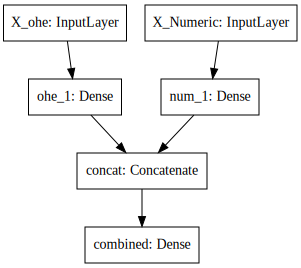

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([ X_train_ohe, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=10, 
          batch_size=50, 
          verbose=1)

yhat = model.predict([X_test_ohe,
                      X_test_num]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

Epoch 1/10
30162/30162 [==============================] - 2s 64us/step - loss: 0.1921 - acc: 0.7379
Epoch 2/10
30162/30162 [==============================] - 2s 55us/step - loss: 0.1583 - acc: 0.7659
Epoch 3/10
30162/30162 [==============================] - 2s 56us/step - loss: 0.1441 - acc: 0.7876
Epoch 4/10
30162/30162 [==============================] - 2s 82us/step - loss: 0.1350 - acc: 0.8035
Epoch 5/10
30162/30162 [==============================] - 2s 55us/step - loss: 0.1290 - acc: 0.8155
Epoch 6/10
30162/30162 [==============================] - 2s 53us/step - loss: 0.1250 - acc: 0.8211
Epoch 7/10
30162/30162 [==============================] - 2s 65us/step - loss: 0.1220 - acc: 0.8246
Epoch 8/10
30162/30162 [==============================] - 2s 58us/step - loss: 0.1198 - acc: 0.8289
Epoch 9/10
30162/30162 [==============================] - 2s 53us/step - loss: 0.1180 - acc: 0.8322
Epoch 10/10
30162/30162 [==============================] - 2s 59us/step - loss: 0.1166 - acc: 0.8355

So the confusion matrix is doing pretty well! But we still are just using an MLP with one hidden layer. We really want to take advantage of the embeddings and crossed columns that are possible with tensorflow. 


** [Back to Slides] **
___

# Crossed Columns and Deep Embeddings
Lets create the network below in steps. This network consists of a number of different paths for the input data to take.
![asdfasfd](https://www.tensorflow.org/images/wide_n_deep.svg)

## Step One: Using Dense embeddings 
First let's try a deeper architecture with dense embeddings for the categorical features, as described in lecture.

- The first decision to make is about the size of the dense feature embeddings. This is essentially a dimensionality reduction step. 
 - This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.
- When using an Embedding, we can leave the variables represented as integers. That is, keras will use the integer representation to figure out how to one-hot-encode the variable. This is great because it means we don't need to change the variable in memory. 

In [17]:
# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] # this is where we will keep track of output of each branch

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = len(np.unique(X_ints_train[-1])) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))
x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)


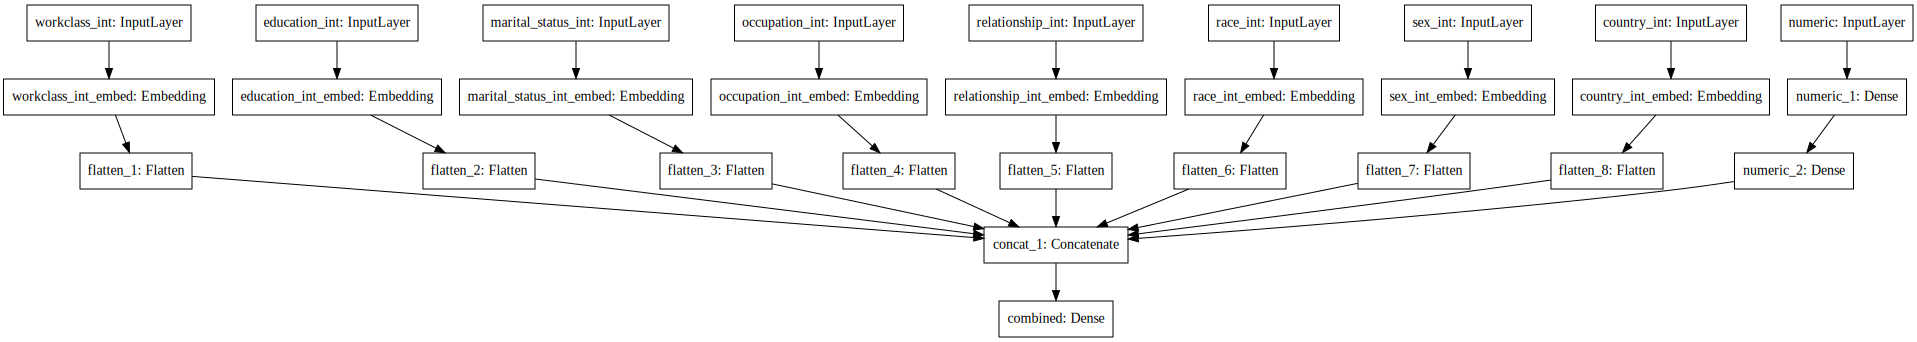

In [18]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_num], # create a list of inputs for embeddings
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
30162/30162 [==============================] - 3s 108us/step - loss: 0.2058 - acc: 0.7295
Epoch 2/10
30162/30162 [==============================] - 3s 99us/step - loss: 0.1726 - acc: 0.7518
Epoch 3/10
30162/30162 [==============================] - 3s 90us/step - loss: 0.1507 - acc: 0.7721
Epoch 4/10
30162/30162 [==============================] - 2s 67us/step - loss: 0.1393 - acc: 0.7916
Epoch 5/10
30162/30162 [==============================] - 2s 68us/step - loss: 0.1322 - acc: 0.8029
Epoch 6/10
30162/30162 [==============================] - 2s 68us/step - loss: 0.1273 - acc: 0.8090
Epoch 7/10
30162/30162 [==============================] - 3s 93us/step - loss: 0.1236 - acc: 0.8155
Epoch 8/10
30162/30162 [==============================] - 2s 69us/step - loss: 0.1208 - acc: 0.8228
Epoch 9/10
30162/30162 [==============================] - 2s 73us/step - loss: 0.1185 - acc: 0.8270
Epoch 10/10
30162/30162 [==============================] - 3s 96us/step - loss: 0.1166 - acc: 0.830

In [20]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10652   708]
 [ 1857  1843]] 0.8296812749003984


That works fairly well using the embeddings. Now let's try to perform the same thing with crossed embeddings.


___


## Step Two: Making Crossed Columns
For this example, we are going to make embeddings for crossed columns. We will perform this step using `sklearn` 

Let's start simple with 
- just a single layer classifier 
- with branches of crossed categorical features as input 
 - one branch for each crossed column

In [25]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'

cross_columns = [['education','occupation'],
                 ['sex', 'marital_status'],
                 ['workclass','occupation'],
                 ['workclass','race','country']
                ]

# we will create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    
    # 3. save encodings in a list for each branch
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories in the crossing
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the crossed encoding
    inputs = Input(shape=(1,),dtype='int32',name='_'.join(cols))
    all_inputs.append(inputs) # save this as input for the keras.Model
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name='_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x) # save for concatenating later
    
# merge the branches together
final_branch = concatenate(all_branch_outputs)
# add a layer after merging
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

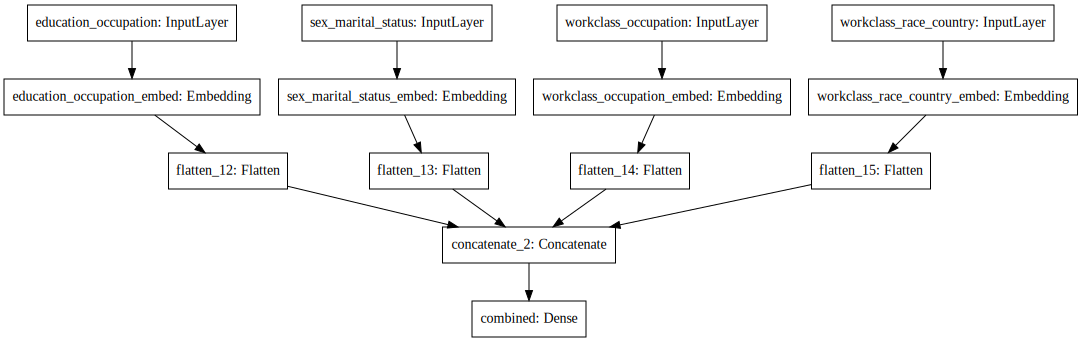

In [26]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [27]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train,
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
30162/30162 [==============================] - 3s 89us/step - loss: 0.2064 - acc: 0.7459
Epoch 2/10
30162/30162 [==============================] - 2s 74us/step - loss: 0.1846 - acc: 0.7511
Epoch 3/10
30162/30162 [==============================] - 3s 93us/step - loss: 0.1783 - acc: 0.7511
Epoch 4/10
30162/30162 [==============================] - 2s 78us/step - loss: 0.1716 - acc: 0.7511
Epoch 5/10
30162/30162 [==============================] - 2s 51us/step - loss: 0.1639 - acc: 0.7511
Epoch 6/10
30162/30162 [==============================] - 2s 59us/step - loss: 0.1566 - acc: 0.7551
Epoch 7/10
30162/30162 [==============================] - 2s 72us/step - loss: 0.1512 - acc: 0.7673
Epoch 8/10
30162/30162 [==============================] - 3s 93us/step - loss: 0.1474 - acc: 0.7840
Epoch 9/10
30162/30162 [==============================] - 2s 59us/step - loss: 0.1445 - acc: 0.7939: 1s - lo
Epoch 10/10
30162/30162 [==============================] - 2s 54us/step - loss: 0.1421 - ac

In [28]:
yhat = np.round(model.predict(X_ints_test))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10838   522]
 [ 2385  1315]] 0.8069721115537849


Wow! That is just using crossed columns and a one layer Linear Classifer! So memorization works fairly well here.


___


## Step Three (Final): Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier!

Wide and deep models can have really interesting and useful properties so they are great to keep in mind when selecting an architecture. Some of the hyperparameters that are specific to this are:
- which features to cross together, typically you only want to cross columns you think are important to be connected--they somehow might create new knowledge by combining.
- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.

In [29]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'

cross_columns = [['education','occupation'],
                 ['relationship','marital_status','sex'],
                 ['race','sex']]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)



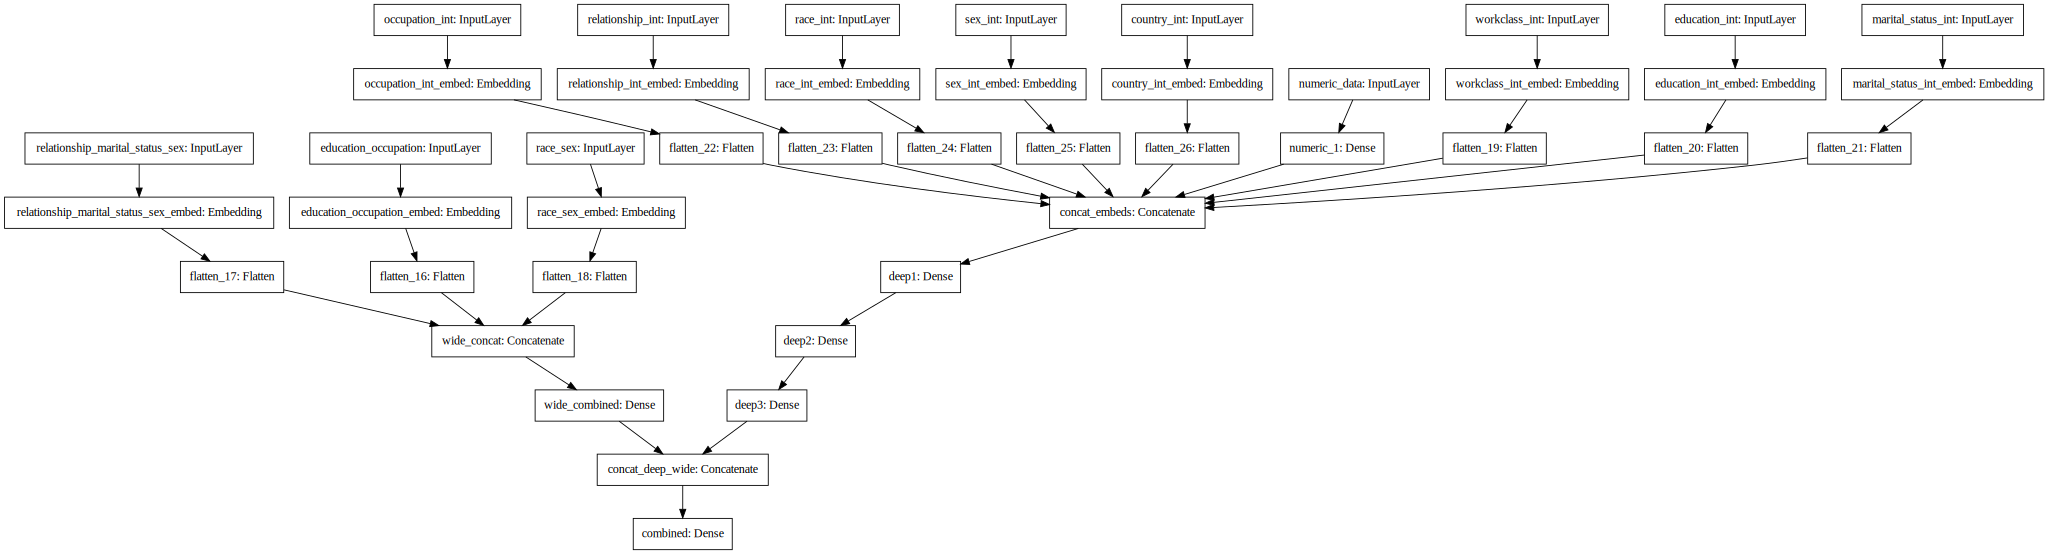

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [31]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 30162 samples, validate on 15060 samples
Epoch 1/10
30162/30162 [==============================] - 9s 287us/step - loss: 0.1085 - acc: 0.8432 - val_loss: 0.1046 - val_acc: 0.8450
Epoch 2/10
30162/30162 [==============================] - 7s 237us/step - loss: 0.1014 - acc: 0.8531 - val_loss: 0.1017 - val_acc: 0.8515
Epoch 3/10
30162/30162 [==============================] - 7s 239us/step - loss: 0.1004 - acc: 0.8550 - val_loss: 0.1013 - val_acc: 0.8538
Epoch 4/10
30162/30162 [==============================] - 7s 242us/step - loss: 0.0997 - acc: 0.8564 - val_loss: 0.1013 - val_acc: 0.8535
Epoch 5/10
30162/30162 [==============================] - 6s 193us/step - loss: 0.0994 - acc: 0.8560 - val_loss: 0.1017 - val_acc: 0.8519
Epoch 6/10
30162/30162 [==============================] - 4s 141us/step - loss: 0.0990 - acc: 0.8575 - val_loss: 0.1010 - val_acc: 0.8541
Epoch 7/10
30162/30162 [==============================] - 4s 135us/step - loss: 0.0987 - acc: 0.8571 - val_loss: 0.1011 - 

In [33]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat), mt.accuracy_score(y_test,yhat))

[[10486   874]
 [ 1343  2357]] 0.8527888446215139


Text(0.5, 0, 'epochs')

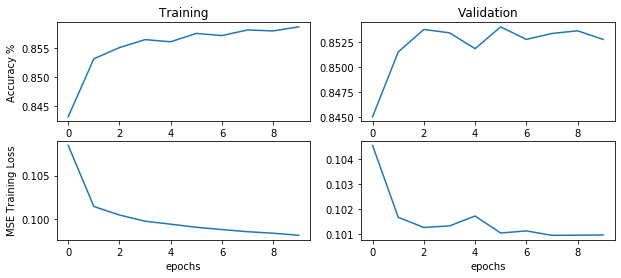

In [34]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

# Making Generalization Better
In what ways might we try to make the model found generalize more concretely?

**Self Test:** What is the best method to make the results better?  
- A. Add Dropout to deep network
- B. Add Dropout to wide network
- C. Perturb the Categorical Data during Training (augmentation)
- D. Add L2 regularization to different layer's weights